# Counting cell neighbors in tissues
When measuring properties of cells in the context of their neighbors, it makes a lot of sense to simulate tissues. For the 2D case, thise can be done using clesperanto's build-in function `artificial_tissue_2d()`

In [1]:
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

cl.OCLArray([[  1,   1,   1, ...,  11,  11,  11],
       [  1,   1,   1, ...,  11,  11,  11],
       [  1,   1,   1, ...,  11,  11,  11],
       ...,
       [166, 166, 166, ..., 176, 176, 176],
       [166, 166, 166, ..., 176, 176, 176],
       [166, 166, 166, ..., 176, 176, 176]], dtype=uint32)
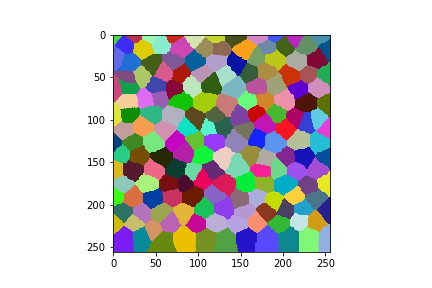

In [2]:
cle.artificial_tissue_2d()

As you can see, the simulated 2D tissue shows the common honeycomb-pattern of cells in tissues with some random variation. The amount of randomness can be controlled by changing the `sigma` value of the Gaussian distribution of the local shift of cell centers in pixel unit.

cl.OCLArray([[  1,   1,   1, ...,  11,  11,  11],
       [  1,   1,   1, ...,  11,  11,  22],
       [  1,   1,   1, ...,  11,  22,  22],
       ...,
       [166, 166, 166, ..., 176, 176, 176],
       [166, 166, 166, ..., 176, 176, 176],
       [166, 166, 166, ..., 176, 176, 176]], dtype=uint32)
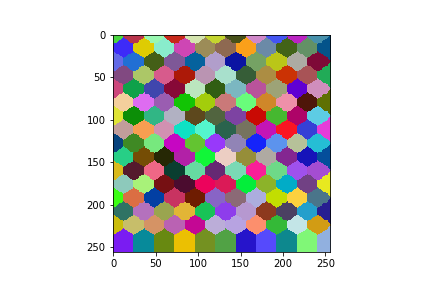

In [3]:
cle.artificial_tissue_2d(random_sigma_x=0, random_sigma_y=0)


Furthermore, the elongation of the cells can be modified by changing the step size of cell center positions in pixel unit.

cl.OCLArray([[ 1,  1,  1, ..., 11, 11, 11],
       [ 1,  1,  1, ..., 11, 11, 11],
       [ 1,  1,  1, ..., 11, 11, 11],
       ...,
       [67, 67, 67, ..., 77, 77, 77],
       [67, 67, 67, ..., 77, 77, 77],
       [67, 67, 67, ..., 77, 77, 77]], dtype=uint32)
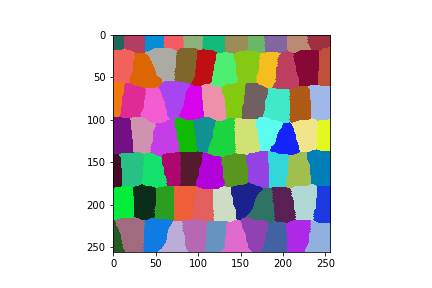

In [4]:
cle.artificial_tissue_2d(delta_y=40)

## Using simulations of tissues for validating neighbor count measurements
A common task in quantitative tissue imaging analysis is counting the number of neighbors. There are multiple algorithms available for that which may, or may not, be invariant against the random variation shown above. Here we use two: 
* We will count the number of cells that are directly touching in at least one pixel.
* We will count the number of cells with centroid positions in a given radius.

We can use both methods from clesperanto to visualize the neighbor-count in color:

In [5]:
labels = cle.artificial_tissue_2d()

cl.OCLArray([[1., 1., 1., ..., 3., 3., 4.],
       [1., 1., 1., ..., 3., 4., 4.],
       [1., 1., 1., ..., 4., 4., 4.],
       ...,
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.]], dtype=float32)
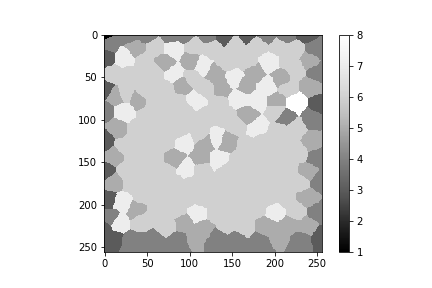
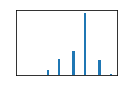

In [6]:
cle.touching_neighbor_count_map(labels)

cl.OCLArray([[2., 2., 2., ..., 3., 3., 3.],
       [2., 2., 2., ..., 3., 3., 3.],
       [2., 2., 2., ..., 3., 3., 3.],
       ...,
       [3., 3., 3., ..., 2., 2., 2.],
       [3., 3., 3., ..., 2., 2., 2.],
       [3., 3., 3., ..., 2., 2., 2.]], dtype=float32)
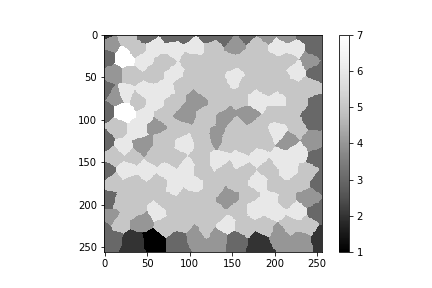
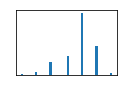

In [7]:
radius = 25

cle.proximal_neighbor_count_map(labels, max_distance=radius)

From these two views, we can see that the algorithms differ quite a bit in counting the number of neighbors locally.

## Varying parameters
In order to investigate how much the algorithms suffer from randomly varying position of the cells, we can apply the two methods in a for-loop varying the sigma parameters introduced above.

Before doing that we define a helper function for visualizing the results.

In [8]:
def measure_and_visualize_neighbor_count(labels):
    # measure
    touching_neighbor_count_map = cle.touching_neighbor_count_map(labels)
    radius = 25
    proximal_neighbor_count_map = cle.proximal_neighbor_count_map(labels, max_distance=radius)
    
    # visualize
    fix, ax = plt.subplots(1, 3, figsize=[10,10])
    cle.imshow(labels, labels=True, plot=ax[0])
    cle.imshow(touching_neighbor_count_map, 
               plot=ax[1], 
               min_display_intensity=0, 
               max_display_intensity=10,
               colormap='rainbow')
    cle.imshow(proximal_neighbor_count_map, 
               plot=ax[2], 
               min_display_intensity=0, 
               max_display_intensity=10,
               colormap='rainbow')

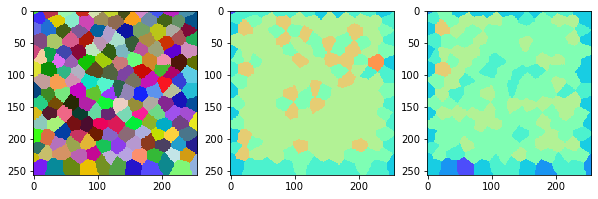

In [9]:
measure_and_visualize_neighbor_count(labels)

Now we can program the for-loop that varies the sigma.

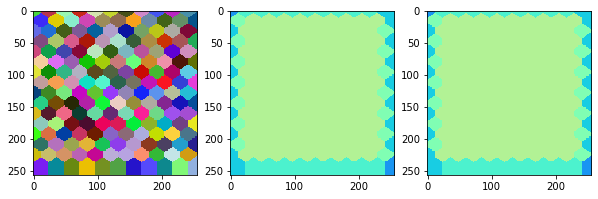

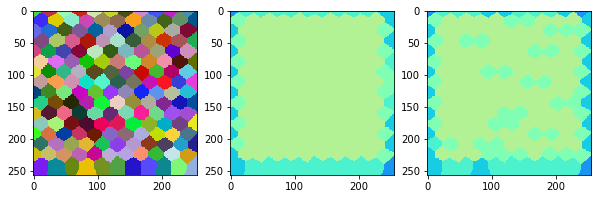

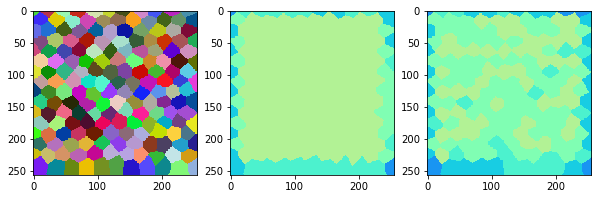

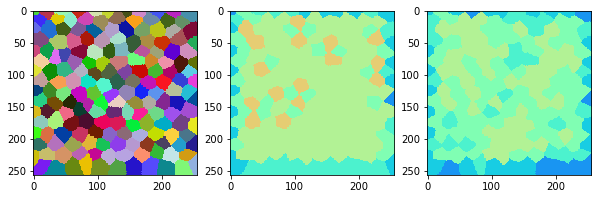

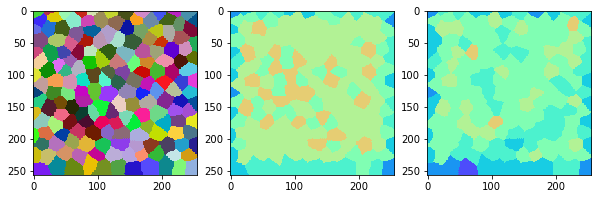

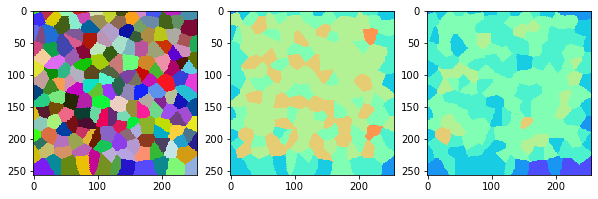

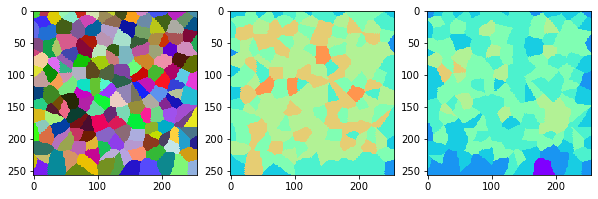

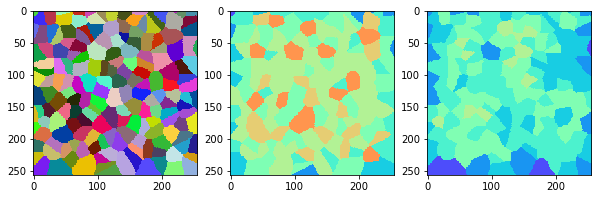

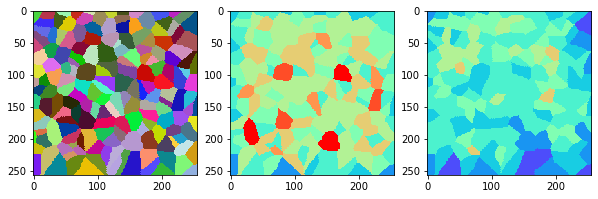

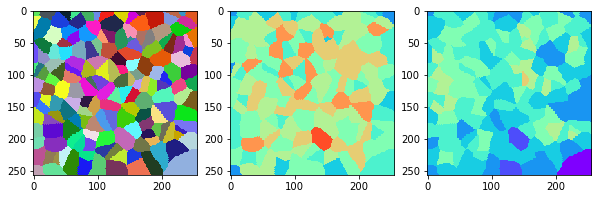

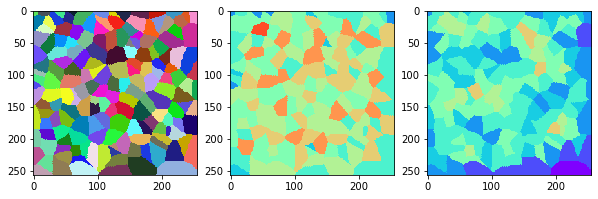

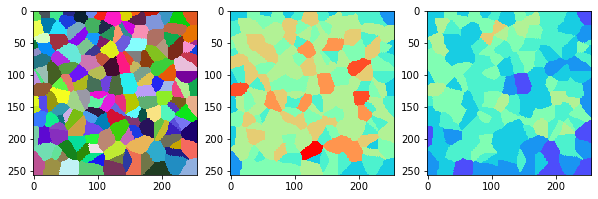

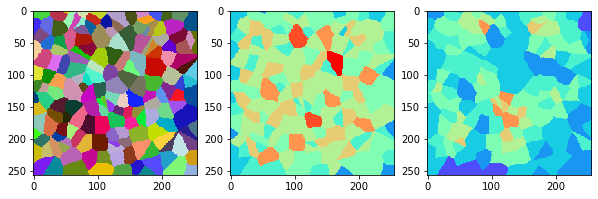

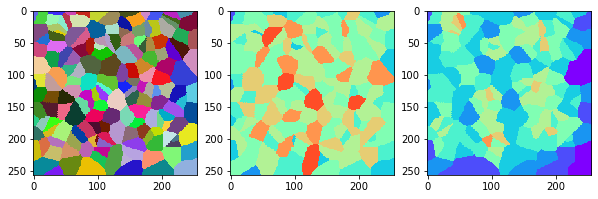

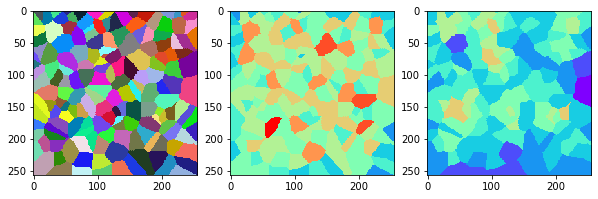

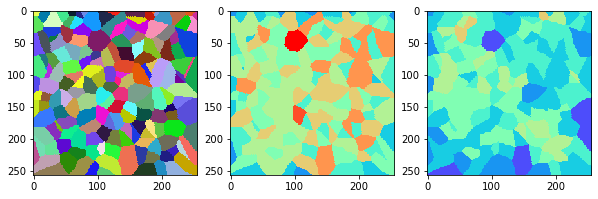

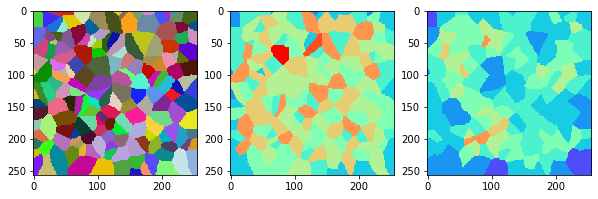

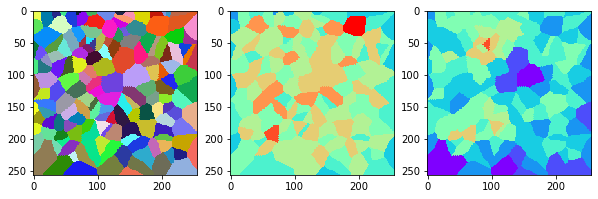

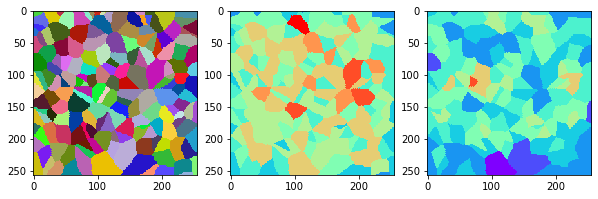

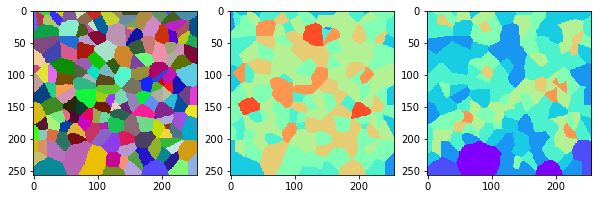

In [10]:
for sigma in range(0, 20, 1):
    cells = cle.artificial_tissue_2d(
        random_sigma_x=sigma, 
        random_sigma_y=sigma)
    
    measure_and_visualize_neighbor_count(cells)

This visualization can be interpreted as follows:
* The touching neighbor count appears to sense more neighbors touching, even though the number of cells per area tissue remains constant.
* The proximal neighbor count has local fluctuations in the neighbor count which on average might cancel out.

We can further investigate these statements by quantitatively measuring the neighbor count and the standard deviation. We again write a helper function similar to the one above but this time it measures the average neighbor count. Additionally, we will count the total number of cells as additional quality check. The helper function will return our measurements as dictionary so that we can conveniently collect them in a pandas DataFrame.

In [11]:
def measure_neighbor_count(labels):
    # measure
    touching_neighbor_count_map = cle.touching_neighbor_count_map(labels)
    radius = 25
    proximal_neighbor_count_map = cle.proximal_neighbor_count_map(labels, max_distance=radius)
    
    # we should not measure number of neighbors in 
    # cells that touch the image border.
    labels_excluding_border = cle.exclude_labels_on_edges(labels)

    touching_neighbor_count_list = cle.read_intensities_from_map(labels_excluding_border, touching_neighbor_count_map)
    proximal_neighbor_count_list = cle.read_intensities_from_map(labels_excluding_border, proximal_neighbor_count_map)

    return {
        "number_of_cells" : [labels_excluding_border.max()],
        "touching_neighbor_count_mean" : [np.mean(touching_neighbor_count_list)],
        "touching_neighbor_count_std" : [np.std(touching_neighbor_count_list)],
        "proximal_neighbor_count_mean" : [np.mean(proximal_neighbor_count_list)],
        "proximal_neighbor_count_std" : [np.std(proximal_neighbor_count_list)]
    }

In [12]:
pd.DataFrame(measure_neighbor_count(labels)).T

,0
number_of_cells,130.000000
touching_neighbor_count_mean,5.908397
touching_neighbor_count_std,0.823791
proximal_neighbor_count_mean,5.190840
proximal_neighbor_count_std,0.782582


We can now run our for-loop again, collect those values and plot them.

In [13]:
statistics_over_sigma = None

for sigma in range(0, 20, 1):
    cells = cle.artificial_tissue_2d(
        random_sigma_x=sigma, 
        random_sigma_y=sigma)
    
    measurements = measure_neighbor_count(cells)
    measurements["sigma"] = sigma
    statistics = pd.DataFrame(measurements)
    
    if statistics_over_sigma is None:
        statistics_over_sigma = pd.DataFrame(statistics)
    else:
        statistics_over_sigma = pd.concat([statistics_over_sigma, statistics])

statistics_over_sigma

,number_of_cells,touching_neighbor_count_mean,touching_neighbor_count_std,proximal_neighbor_count_mean,proximal_neighbor_count_std,sigma
0,126.0,5.984252,0.176771,5.984252,0.176771,0
0,129.0,5.961538,0.228838,5.692307,0.552563,1
0,129.0,5.961538,0.228838,5.453846,0.621556,2
0,128.0,5.891473,0.759848,5.201550,0.892517,3
0,126.0,5.968504,0.762683,4.976378,0.846154,4
0,130.0,5.786260,1.229458,4.404580,1.075605,5
0,125.0,5.928571,1.229134,4.317461,0.939865,6
0,127.0,5.703125,1.480917,4.429688,1.315078,7
0,129.0,5.761539,1.507947,4.230769,1.224986,8
0,121.0,5.754098,1.784778,3.975410,1.217786,9


First, let's plot the neighbor count together with the standard error as error bar.

Text(0, 0.5, 'neighbor count')

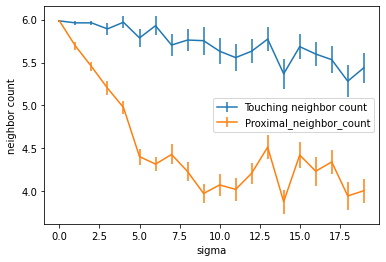

In [14]:
plt.errorbar(x=statistics_over_sigma["sigma"], 
             y=statistics_over_sigma["touching_neighbor_count_mean"],
             yerr=statistics_over_sigma["touching_neighbor_count_std"] / 
                  np.sqrt(statistics_over_sigma["number_of_cells"])
            )
plt.errorbar(x=statistics_over_sigma["sigma"], 
             y=statistics_over_sigma["proximal_neighbor_count_mean"],
             yerr=statistics_over_sigma["proximal_neighbor_count_std"] / 
                  np.sqrt(statistics_over_sigma["number_of_cells"])
            )
plt.legend(["Touching neighbor count", "Proximal_neighbor_count"])
plt.xlabel("sigma")
plt.ylabel("neighbor count")

Using this visualization, we could argue that the number of touching neighbors is the more stable measurement in the presence of varying cell positions. Also note that the tissues shown above might not be the best representation of biological tissues.

Last but not least a sanity check if the number of cells in the image was more or less independent from the sigma.

Text(0, 0.5, 'Cell count')

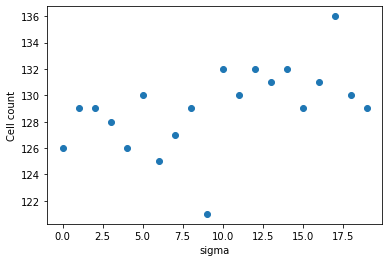

In [15]:
plt.scatter(x=statistics_over_sigma["sigma"],
            y=statistics_over_sigma["number_of_cells"])
plt.xlabel("sigma")
plt.ylabel("Cell count")

In [16]:
np.mean(statistics_over_sigma["number_of_cells"]), np.std(statistics_over_sigma["number_of_cells"])

(129.1, 3.0805843)

## Exercise
Repeat the experiment shown above with cells that are elongated along x. If the conclusion is different, can you explain why?